### Contributors
AmirMohammad Bandari (401110278) & Pouria Mahmoudkhan (401110289)

### Including Libraries

In [36]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import Counter

# reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Phase 1: Preparing Data & EDA

downloading data in `./data` folder and splitting it into `train`, `validation`, and `test`:

In [37]:
transform = transforms.Compose([
    transforms.ToTensor()
])

data_root = './data'
train_full = datasets.FashionMNIST(root=data_root, train=True, download=True, transform=transform)
test_ds = datasets.FashionMNIST(root=data_root, train=False, download=True, transform=transform)

n_train = int(0.9 * len(train_full))
n_val = len(train_full) - n_train
train_ds, val_ds = random_split(train_full, [n_train, n_val], generator=torch.Generator().manual_seed(seed))

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=torch.cuda.is_available())
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=torch.cuda.is_available())

len(train_ds), len(val_ds), len(test_ds), train_ds[0][0].shape

100%|██████████| 26.4M/26.4M [00:09<00:00, 2.74MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 297kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.12MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.26MB/s]


(54000, 6000, 10000, torch.Size([1, 28, 28]))

sanity: show a batch 25 images with labels

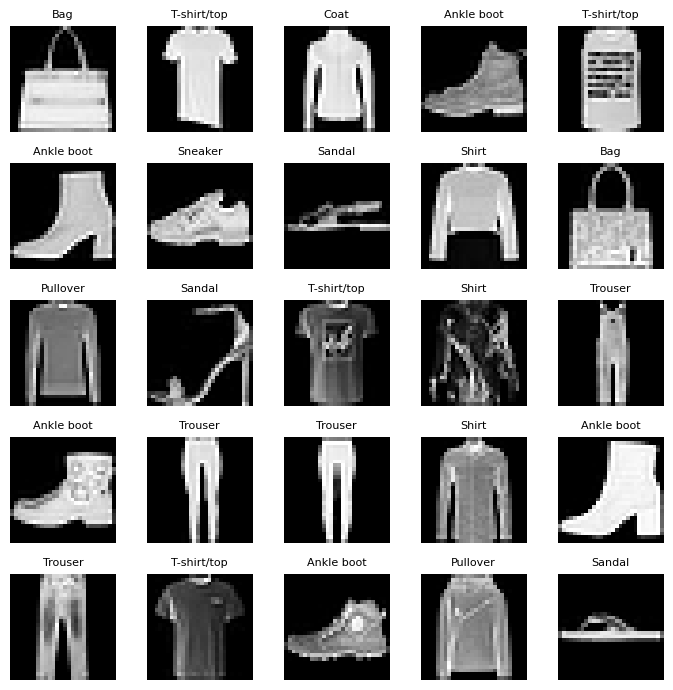

In [38]:
classes = train_full.classes
x, y = next(iter(train_loader))
x = x[:25]
y = y[:25]

plt.figure(figsize=(7,7))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x[i].squeeze(0), cmap='gray')
    plt.title(classes[int(y[i])], fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

EDA: class distribution in training set

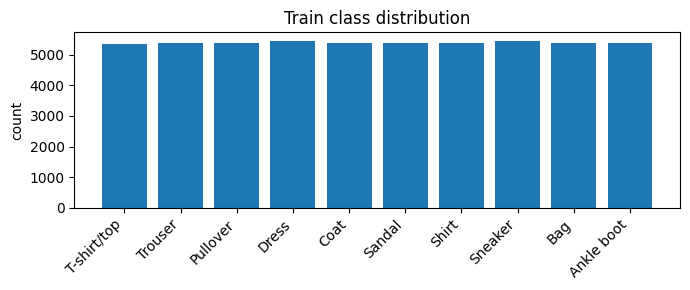

In [39]:
train_labels = [int(train_full.targets[i]) for i in train_ds.indices]
cnt = Counter(train_labels)
xs = np.arange(10)
vals = np.array([cnt[i] for i in xs])

plt.figure(figsize=(7,3))
plt.bar(xs, vals)
plt.xticks(xs, classes, rotation=45, ha='right')
plt.ylabel('count')
plt.title('Train class distribution')
plt.tight_layout()
plt.show()

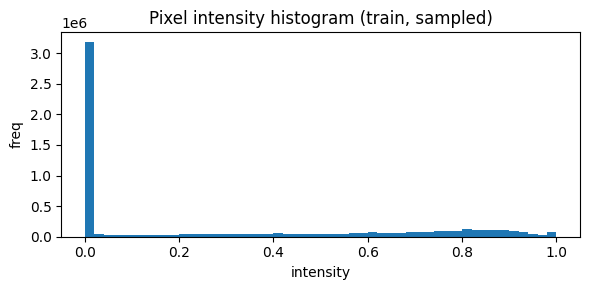

In [40]:
# pixel intensity histogram (sampled for speed)
def sample_pixels(loader, max_batches=80):
    px = []
    for i, (x, _) in enumerate(loader):
        px.append(x.view(-1).cpu().numpy())
        if i+1 >= max_batches:
            break
    px = np.concatenate(px, axis=0)
    return px

px = sample_pixels(train_loader, max_batches=60)
plt.figure(figsize=(6,3))
plt.hist(px, bins=50)
plt.title('Pixel intensity histogram (train, sampled)')
plt.xlabel('intensity')
plt.ylabel('freq')
plt.tight_layout()
plt.show()

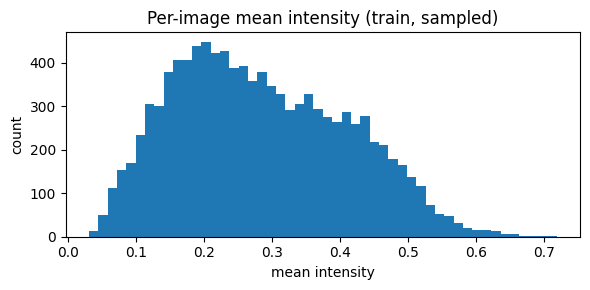

In [41]:
# image-level histogram: mean pixel intensity per image (sampled)
means = []
for i, (x, _) in enumerate(train_loader):
    means.append(x.view(x.size(0), -1).mean(dim=1).cpu().numpy())
    if i >= 80:
        break
means = np.concatenate(means, axis=0)

plt.figure(figsize=(6,3))
plt.hist(means, bins=50)
plt.title('Per-image mean intensity (train, sampled)')
plt.xlabel('mean intensity')
plt.ylabel('count')
plt.tight_layout()
plt.show()

## Helpers
here we are defining some helper functions:
- `to_img_grid` gets a tensor in input and view it as a grid of images, it helps in demonstrations
- `evaluate_vae` abstracts away the of evaluation process of our models (they all use a same function)
- `train_vae` abstracts away the training process of our models (they all use a same function)

In [42]:
def to_img_grid(x, nrow, ncol, figsize=(10,4), title=None):
    x = x.detach().cpu()
    plt.figure(figsize=figsize)
    for i in range(nrow*ncol):
        plt.subplot(nrow, ncol, i+1)
        plt.imshow(x[i].squeeze(0), cmap='gray')
        plt.axis('off')
    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def evaluate_vae(model, loader, beta=1.0):
    model.eval()
    rec_sum, kld_sum, total_sum, n = 0.0, 0.0, 0.0, 0
    for x, _ in loader:
        x = x.to(device)
        out = model(x)
        x_hat, mu, logvar = out["x_hat"], out["mu"], out["logvar"]
        rec = F.binary_cross_entropy(x_hat, x, reduction='sum')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        total = rec + beta * kld
        rec_sum += rec.item()
        kld_sum += kld.item()
        total_sum += total.item()
        n += x.size(0)
    return {
        "recon_per_img": rec_sum / n,
        "kld_per_img": kld_sum / n,
        "total_per_img": total_sum / n
    }

def train_vae(model, train_loader, val_loader, epochs=10, lr=2e-3, beta=1.0, warmup_epochs=0):
    model.to(device)
    opt = Adam(model.parameters(), lr=lr)
    hist = {"train_total":[], "val_total":[], "train_rec":[], "train_kld":[], "val_rec":[], "val_kld":[]}
    for ep in range(1, epochs+1):
        model.train()
        rec_sum, kld_sum, tot_sum, n = 0.0, 0.0, 0.0, 0
        if warmup_epochs > 0:
            beta_ep = beta * min(1.0, ep / warmup_epochs)
        else:
            beta_ep = beta
        for x, _ in train_loader:
            x = x.to(device)
            out = model(x)
            x_hat, mu, logvar = out["x_hat"], out["mu"], out["logvar"]
            rec = F.binary_cross_entropy(x_hat, x, reduction='sum')
            kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = rec + beta_ep * kld
            opt.zero_grad()
            loss.backward()
            opt.step()
            rec_sum += rec.item()
            kld_sum += kld.item()
            tot_sum += loss.item()
            n += x.size(0)

        tr = {"recon_per_img": rec_sum/n, "kld_per_img": kld_sum/n, "total_per_img": tot_sum/n}
        va = evaluate_vae(model, val_loader, beta=beta)
        hist["train_total"].append(tr["total_per_img"])
        hist["val_total"].append(va["total_per_img"])
        hist["train_rec"].append(tr["recon_per_img"])
        hist["train_kld"].append(tr["kld_per_img"])
        hist["val_rec"].append(va["recon_per_img"])
        hist["val_kld"].append(va["kld_per_img"])
        print(f"ep {ep:02d} | beta={beta_ep:.3f} | train total {tr['total_per_img']:.2f} rec {tr['recon_per_img']:.2f} kld {tr['kld_per_img']:.2f} | val total {va['total_per_img']:.2f}")
    return hist


# Phase 2: VAE implementation & quality improvement

### Define VAE Model

We define our base model which has a fully connected architecture, a Multi-Layer Perceptron.
We suppose our latent dimension to be 20.

In [ ]:
class MLPVAE(nn.Module):
    def __init__(self, z_dim=20, h_dim=400):
        super().__init__()
        self.z_dim = z_dim
        self.enc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, h_dim),
            nn.ReLU()
        )
        self.mu = nn.Linear(h_dim, z_dim)
        self.logvar = nn.Linear(h_dim, z_dim)
        self.dec = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, 28*28),
            nn.Sigmoid()
        )

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.enc(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparam(mu, logvar)
        x_hat = self.dec(z).view(-1, 1, 28, 28)
        return {"x_hat": x_hat, "mu": mu, "logvar": logvar, "z": z}

@torch.no_grad()
def recon_samples(model, loader, n=20):
    model.eval()
    x, _ = next(iter(loader))
    x = x[:n].to(device)
    out = model(x)
    return x, out["x_hat"]

@torch.no_grad()
def sample_prior(model, n=50):
    model.eval()
    z = torch.randn(n, model.z_dim).to(device)
    x_hat = model.dec(z).view(-1, 1, 28, 28)
    return x_hat

In [ ]:
vae_base = MLPVAE(z_dim=20, h_dim=400).to(device)
hist_base = train_vae(vae_base, train_loader, val_loader, epochs=10, lr=2e-3, beta=1.0)

base_test = evaluate_vae(vae_base, test_loader, beta=1.0)
base_test

In [ ]:
# reconstructions (20)
x_in, x_out = recon_samples(vae_base, test_loader, n=20)
to_img_grid(x_in, 2, 10, figsize=(12,3), title="Baseline: inputs")
to_img_grid(x_out, 2, 10, figsize=(12,3), title="Baseline: reconstructions")

In [ ]:
# sampling (50)
samp = sample_prior(vae_base, n=50)
to_img_grid(samp, 5, 10, figsize=(12,6), title="Baseline: prior samples")


Now we define our improved architecture.
This new version has a convolution based structure.
- First a layer of 32-channeled 4x4 convolution with stride 2 and padding 1.
- Then a layer of 64-channeled 4x4 convolution with stride 2 and padding 1.
- Then finally a 128-channeled 3x3 convolution with stride and padding 1.

Leaving us with 128 channels with size 7x7.
This enters a linear perceptron layer.

The decoder is built to be the inverse of this structure.

Because this structure uses our inductive bias, it will probably give a better result.

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, z_dim=32):
        super().__init__()
        self.z_dim = z_dim

        self.enc_conv = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 7x7
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 1, 1),# 7x7
            nn.ReLU()
        )
        self.enc_fc = nn.Linear(128*7*7, 256)
        self.mu = nn.Linear(256, z_dim)
        self.logvar = nn.Linear(256, z_dim)

        self.dec_fc = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128*7*7),
            nn.ReLU()
        )
        self.dec_deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 28x28
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Sigmoid()
        )

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.enc_conv(x).view(x.size(0), -1)
        h = F.relu(self.enc_fc(h))
        mu = self.mu(h)
        logvar = self.logvar(h)
        z = self.reparam(mu, logvar)
        g = self.dec_fc(z).view(-1, 128, 7, 7)
        x_hat = self.dec_deconv(g)
        return {"x_hat": x_hat, "mu": mu, "logvar": logvar, "z": z}

@torch.no_grad()
def sample_prior_conv(model, n=50):
    model.eval()
    z = torch.randn(n, model.z_dim).to(device)
    g = model.dec_fc(z).view(-1, 128, 7, 7)
    x_hat = model.dec_deconv(g)
    return x_hat


In [ ]:
vae_imp = ConvVAE(z_dim=32).to(device)
hist_imp = train_vae(vae_imp, train_loader, val_loader, epochs=12, lr=2e-3, beta=1.0, warmup_epochs=6)

imp_test = evaluate_vae(vae_imp, test_loader, beta=1.0)
imp_test

In [ ]:
# before vs after (reconstruction)
x_in, x_out_base = recon_samples(vae_base, test_loader, n=20)
_, x_out_imp = recon_samples(vae_imp, test_loader, n=20)

to_img_grid(x_out_base, 2, 10, figsize=(12,3), title="Baseline reconstructions")
to_img_grid(x_out_imp, 2, 10, figsize=(12,3), title="Improved reconstructions")

In [ ]:
# before vs after (sampling)
samp_base = sample_prior(vae_base, n=50)
samp_imp = sample_prior_conv(vae_imp, n=50)
to_img_grid(samp_base, 5, 10, figsize=(12,6), title="Baseline samples")
to_img_grid(samp_imp, 5, 10, figsize=(12,6), title="Improved samples")


We now examine our test metrics

In [ ]:
def print_table(rows, headers):
    w = [max(len(h), max(len(str(r[i])) for r in rows)) for i, h in enumerate(headers)]
    line = " | ".join(h.ljust(w[i]) for i, h in enumerate(headers))
    sep = "-+-".join("-"*w[i] for i in range(len(headers)))
    print(line)
    print(sep)
    for r in rows:
        print(" | ".join(str(r[i]).ljust(w[i]) for i in range(len(headers))))

rows = [
    ["MLP VAE (base)", f"{base_test['recon_per_img']:.2f}", f"{base_test['kld_per_img']:.2f}", f"{base_test['total_per_img']:.2f}"],
    ["Conv VAE (imp)", f"{imp_test['recon_per_img']:.2f}", f"{imp_test['kld_per_img']:.2f}", f"{imp_test['total_per_img']:.2f}"],
]
print_table(rows, ["model", "recon/img", "kld/img", "total/img"])


# Phase 3: Controlling latent space

Here, by changing the regularization parameter beta, we search for the optimal hyperparameter.
First we define a function for our latent traversal.

In [ ]:
@torch.no_grad()
def latent_traversal(model, x, dims, steps=7, span=3.0):
    model.eval()
    x = x.to(device)
    out = model(x)
    mu = out["mu"][0]
    z0 = mu.clone()

    vals = torch.linspace(-span, span, steps, device=device)
    grids = []
    for d in dims:
        zs = []
        for v in vals:
            z = z0.clone()
            z[d] = v
            zs.append(z.unsqueeze(0))
        zs = torch.cat(zs, dim=0)
        if isinstance(model, ConvVAE):
            g = model.dec_fc(zs).view(-1, 128, 7, 7)
            x_hat = model.dec_deconv(g)
        else:
            x_hat = model.dec(zs).view(-1, 1, 28, 28)
        grids.append(x_hat)
    return grids


Now we train our three models.

In [ ]:
betas = [0.5, 1.0, 4.0]
beta_models = {}
beta_tests = {}

for b in betas:
    m = ConvVAE(z_dim=32).to(device)
    _ = train_vae(m, train_loader, val_loader, epochs=8, lr=2e-3, beta=b, warmup_epochs=4)
    beta_models[b] = m
    beta_tests[b] = evaluate_vae(m, test_loader, beta=b)

rows = [[f"beta={b}", f"{beta_tests[b]['recon_per_img']:.2f}", f"{beta_tests[b]['kld_per_img']:.2f}", f"{beta_tests[b]['total_per_img']:.2f}"] for b in betas]
print_table(rows, ["setting", "recon/img", "kld/img", "total/img"])


In [ ]:
# traversal for each beta
x0, _ = next(iter(test_loader))
x0 = x0[:1]
dims = [0, 3, 7, 12, 20]
for b in betas:
    grids = latent_traversal(beta_models[b], x0, dims=dims, steps=7, span=3.0)
    for i, d in enumerate(dims):
        to_img_grid(grids[i], 1, 7, figsize=(10,2), title=f"beta={b} | dim {d} traversal (-3..+3)")


# Phase 4: Image generation with labels

In [ ]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=20, num_classes=10):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder (image + label)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28 + num_classes, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(200, latent_dim)
        self.fc_logvar = nn.Linear(200, latent_dim)

        # Decoder (latent + label)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def one_hot(self, labels):
        return F.one_hot(labels, num_classes=self.num_classes).float()

    def encode(self, x, labels):
        labels = self.one_hot(labels)
        x = torch.cat([x.view(x.size(0), -1), labels], dim=1)
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        labels = self.one_hot(labels)
        z = torch.cat([z, labels], dim=1)
        recon = self.decoder(z)
        return recon.view(-1, 1, 28, 28)

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, labels)
        return recon, mu, logvar

In [ ]:
def cvae_loss(recon_x, x, mu, logvar, beta=1.0):
    x_scaled = (x + 1.0) / 2.0

    recon_loss = F.binary_cross_entropy(
        recon_x.view(-1, 28*28),
        x_scaled.view(-1, 28*28),
        reduction='sum'
    )

    kld_loss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return (recon_loss + beta * kld_loss) / x.size(0)


In [ ]:
latent_dim = 20
cvae = CVAE(latent_dim).to(device)
optimizer = Adam(cvae.parameters(), lr=1e-3)

epochs = 20
train_losses = []
val_losses = []

for epoch in range(epochs):
    cvae.train()
    train_loss = 0

    for data, labels in train_loader:
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = cvae(data, labels)
        loss = cvae_loss(recon, data, mu, logvar)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    cvae.eval()
    val_loss = 0

    with torch.no_grad():
        for data, labels in val_loader:
            data = data.to(device)
            labels = labels.to(device)

            recon, mu, logvar = cvae(data, labels)
            val_loss += cvae_loss(recon, data, mu, logvar).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")

In [ ]:
cvae.eval()

num_classes = 10
samples_per_class = 20

fig, axes = plt.subplots(num_classes, samples_per_class,
                         figsize=(samples_per_class, num_classes))

with torch.no_grad():
    for cls in range(num_classes):
        labels = torch.full((samples_per_class,),
                            cls,
                            device=device)

        z = torch.randn(samples_per_class,
                        latent_dim,
                        device=device)

        generated = cvae.decode(z, labels).cpu()

        for i in range(samples_per_class):
            axes[cls, i].imshow(generated[i][0],
                                cmap='gray')
            axes[cls, i].axis('off')

plt.tight_layout()
plt.show()

### Cmp

In [ ]:
def evaluate_test_loss_vae(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            recon, mu, logvar = model(x)
            loss = vae_loss(recon, x, mu, logvar)
            total_loss += loss.item()

    return total_loss / len(loader)


def evaluate_test_loss_cvae(model, loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x, labels in loader:
            x = x.to(device)
            labels = labels.to(device)
            recon, mu, logvar = model(x, labels)
            loss = cvae_loss(recon, x, mu, logvar)
            total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
vae_test_loss = evaluate_test_loss_vae(vae_base, test_loader)
cvae_test_loss = evaluate_test_loss_cvae(cvae, test_loader)

print("=== Test Loss Comparison ===")
print(f"VAE  test loss: {vae_test_loss:.4f}")
print(f"CVAE test loss: {cvae_test_loss:.4f}")


In [ ]:
def compare_reconstruction_test(vae, cvae, loader, n=8):

    vae.eval()
    cvae.eval()

    x, labels = next(iter(loader))
    x = x[:n].to(device)
    labels = labels[:n].to(device)

    with torch.no_grad():
        recon_vae, _, _ = vae(x)
        recon_cvae, _, _ = cvae(x, labels)

    fig, axes = plt.subplots(3, n, figsize=(2*n, 6))

    for i in range(n):
        axes[0, i].imshow(x[i][0].cpu(), cmap='gray')
        axes[0, i].set_title(class_names[labels[i]])
        axes[0, i].axis('off')

        axes[1, i].imshow(recon_vae[i][0].cpu(), cmap='gray')
        axes[1, i].set_title("VAE")
        axes[1, i].axis('off')

        axes[2, i].imshow(recon_cvae[i][0].cpu(), cmap='gray')
        axes[2, i].set_title("CVAE")
        axes[2, i].axis('off')

    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("VAE")
    axes[2, 0].set_ylabel("CVAE")

    plt.tight_layout()
    plt.show()


compare_reconstruction_test(vae_base, cvae, test_loader)


In [ ]:
def generate_per_class(cvae, latent_dim, samples=10):

    cvae.eval()

    fig, axes = plt.subplots(10, samples,
                             figsize=(samples, 10))

    with torch.no_grad():
        for cls in range(10):

            labels = torch.full(
                (samples,),
                cls,
                dtype=torch.long,
                device=device
            )

            z = torch.randn(samples,
                            latent_dim,
                            device=device)

            imgs = cvae.decode(z, labels)

            for i in range(samples):
                axes[cls, i].imshow(
                    imgs[i][0].cpu(),
                    cmap='gray'
                )
                axes[cls, i].axis('off')

            axes[cls, 0].set_ylabel(class_names[cls])

    plt.tight_layout()
    plt.show()


generate_per_class(cvae, latent_dim)


In [ ]:
def compare_sampling_models(vae, cvae, latent_dim, n=10):

    vae.eval()
    cvae.eval()

    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))

    with torch.no_grad():

        z = torch.randn(n, latent_dim, device=device)

        # VAE sampling
        vae_imgs = vae.decode(z)

        # CVAE sampling (random labels)
        labels = torch.randint(0, 10, (n,),
                               device=device)
        cvae_imgs = cvae.decode(z, labels)

    for i in range(n):
        axes[0, i].imshow(vae_imgs[i][0].cpu(),
                          cmap='gray')
        axes[0, i].axis('off')

        axes[1, i].imshow(cvae_imgs[i][0].cpu(),
                          cmap='gray')
        axes[1, i].set_title(class_names[labels[i]])
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("VAE")
    axes[1, 0].set_ylabel("CVAE")

    plt.tight_layout()
    plt.show()


compare_sampling_models(vae_base, cvae, latent_dim)


# Phase 5: Report